In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import re
from datetime import datetime
from isoweek import Week

data = pd.read_csv("data/DK_2010_2025_posfrac.csv", dtype=str)

# Compute a date column:
# parse ISO week format (e.g. "2020-W12") into a date (Monday of that ISO week)
def iso_week_to_date(iso_str):
    """
    Convert 'YYYY-Www' string into a Python date.
    Example: "2020-W12" -> Monday of the 12th ISO week of 2020.
    """
    match = re.match(r"(\d{4})-W(\d{1,2})", iso_str)
    if not match:
        return None
    year, week = match.groups()
    year, week = int(year), int(week)
    return Week(year, week).monday()

# Create a 'date' column from 'year_Week'
data["date"] = data["year_Week"].apply(iso_week_to_date)

data['date'] = pd.to_datetime(data["date"])

# Look only at pre-COVID times:
data = data[data["date"] < np.datetime64(iso_week_to_date("2020-W12"))]

inc_proxy = data['PosFrac'].fillna(0).values

inc_proxy = np.float64(inc_proxy)

In [2]:
from astropy.timeseries import LombScargle

I = inc_proxy
I_demeaned = I # Use I directly
t_loc = np.arange(len(I_demeaned))/52

dt = t_loc[1] - t_loc[0] # in years
n = len(I_demeaned)

fhat = np.fft.rfft(I_demeaned)
power = np.abs(fhat)**2

freqs = np.fft.rfftfreq(n, d=dt)

freqs_nonzero = freqs[1:]
power_nonzero_loc = power[1:]
periods = 1.0 / freqs_nonzero 

mask = (periods >= 0.5) & (periods <= 11)
periods = periods[mask]
eps_log = 0.001
power_nonzero = power_nonzero_loc[mask]/n

min_freq = 1.0 / 10.0 
max_freq = 1/0.4

ls = LombScargle(t_loc, I)

frequency, power_loc = ls.autopower(
    minimum_frequency=min_freq,
    maximum_frequency=max_freq,
    samples_per_peak=50,  
    normalization='psd'
)

period_ls = 1/frequency
power_ls = power_loc

Peak LS: 4.916067146282973
Peak Fourier: 5.134615384615385


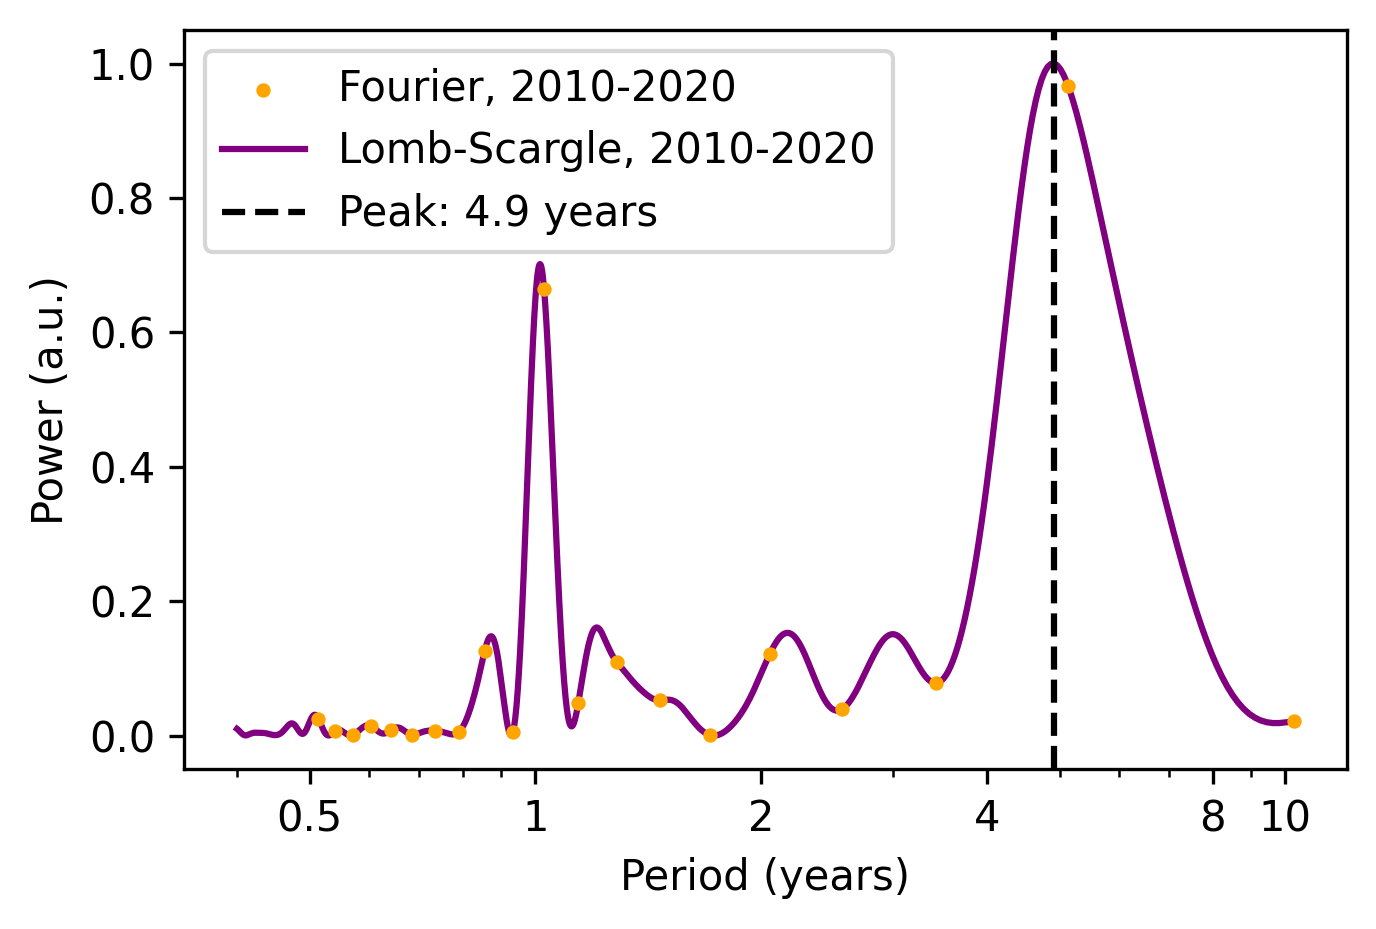

In [3]:
plt.figure(figsize=(5, 3.2), dpi=300)

periods = periods[::1]
power_nonzero = power_nonzero[::1]

factor = 1/np.max(power_ls[period_ls > 0.5])

power_nonzero *= factor
power_ls *= factor

color1 = "orange"
color2 = "purple"

plt.scatter(periods, power_nonzero, label="Fourier, 2010-2020", s=6, color=color1, zorder=2)
plt.plot(period_ls, power_ls, label="Lomb-Scargle, 2010-2020", color=color2, zorder=1)

plt.xscale('log')
plt.xticks([0.5, 1, 2, 4, 8, 10], labels=[0.5, 1, 2, 4, 8, 10])

# Identify dominant multi-year peak
peak_idx = np.argmax(power_ls[period_ls > 1.5])
dominant_period = period_ls[period_ls > 1.5][peak_idx]
print("Peak LS:", dominant_period)
plt.axvline(dominant_period, color='black', linestyle='--', label=f"Peak: {dominant_period:.1f} years", linewidth=1.5)
plt.xlabel("Period (years)")
plt.ylabel("Power (a.u.)")
plt.legend()

peak_idx = np.argmax(power_nonzero[periods > 1.5])
dominant_period = periods[periods > 1.5][peak_idx]
print("Peak Fourier:", dominant_period)

# 1958

In [4]:
csvfile = "data/DK_1958_1995_pseudofrac.csv"

data = pd.read_csv(csvfile, dtype=float)

sqrt_transform = True

# Square root transform:
data["PseudoFrac"]
if sqrt_transform:
    pretransform_mean = data["PseudoFrac"].mean()
    data["PseudoFrac"] = np.sqrt(data["PseudoFrac"])
    data["PseudoFrac"] = data["PseudoFrac"] * pretransform_mean/data["PseudoFrac"].mean()
    
#maxtime = 1973.0
#inc_proxy = data[data['time'] <= maxtime]['PseudoFrac'].fillna(0).values
mintime = 1973.0
inc_proxy = data[data['time'] > mintime]['PseudoFrac'].fillna(0).values
inc_proxy = np.float64(inc_proxy)

In [5]:
from astropy.timeseries import LombScargle

def get_spectra(I, time_units_per_year):
    # 1) (Optional) Remove any mean (DC offset) so that the FFT isn't dominated by zero freq
    #I_demeaned = I - np.mean(I)
    # Or don't:
    I_demeaned = I
    t_loc = np.arange(len(I_demeaned))/time_units_per_year
    
    # 2) We'll do an FFT. First compute the sampling interval dt in years.
    dt = t_loc[1] - t_loc[0]  # in years
    n = len(I_demeaned)
    
    # 3) Compute the Discrete Fourier Transform
    #    np.fft.rfft gives the one-sided spectrum (0 ... Nyquist freq)
    fhat = np.fft.rfft(I_demeaned)        # Complex DFT coefficients
    power = np.abs(fhat)**2               # Power is magnitude squared
    
    # 4) Associated frequencies (one-sided)
    freqs = np.fft.rfftfreq(n, d=dt)      # in cycles/year
    
    # 5) Convert freq to period in years, ignoring zero frequency (freq[0] = 0)
    #    to avoid division by zero, we can skip the freq=0 component
    freqs_nonzero = freqs[1:]      # from index 1 to end
    power_nonzero_loc = power[1:]
    periods = 1.0 / freqs_nonzero  # in years
    
    # 6) (Optionally) limit the range to 0.5–10 years, just as in Lomb–Scargle
    mask = (periods >= 0.10) & (periods <= 10)
    periods = periods[mask]
    eps_log = 0.001
    power_nonzero = power_nonzero_loc[mask]/n
    
    # 1. Specify the frequency range. 
    #    If you want to see periods from, say, half a year (0.5 yr) to 10 years,
    #    that translates to frequencies from 1/10 to 2 cycles/year.
    min_freq = 1.0 / 10.0  # 1/10 = 0.1 cyc/yr
    max_freq = 1/0.4         # 2 cyc/yr = 0.5-year period
    
    # 2. Create a LombScargle object:
    ls = LombScargle(t_loc, I)
    
    # 3. Evaluate the periodogram over that frequency range:
    frequency, power_loc = ls.autopower(
        minimum_frequency=min_freq,
        maximum_frequency=max_freq,
        samples_per_peak=50,  # oversampling factor, can adjust for resolution
        normalization='psd'
    )
    
    # 4. Convert frequency to period, if you prefer seeing period on the x-axis.
    period_ls = 1/frequency
    power_ls = power_loc
    return periods, power_nonzero, period_ls, power_ls

early: 4.557823129251701
Peak Fourier: 4.25


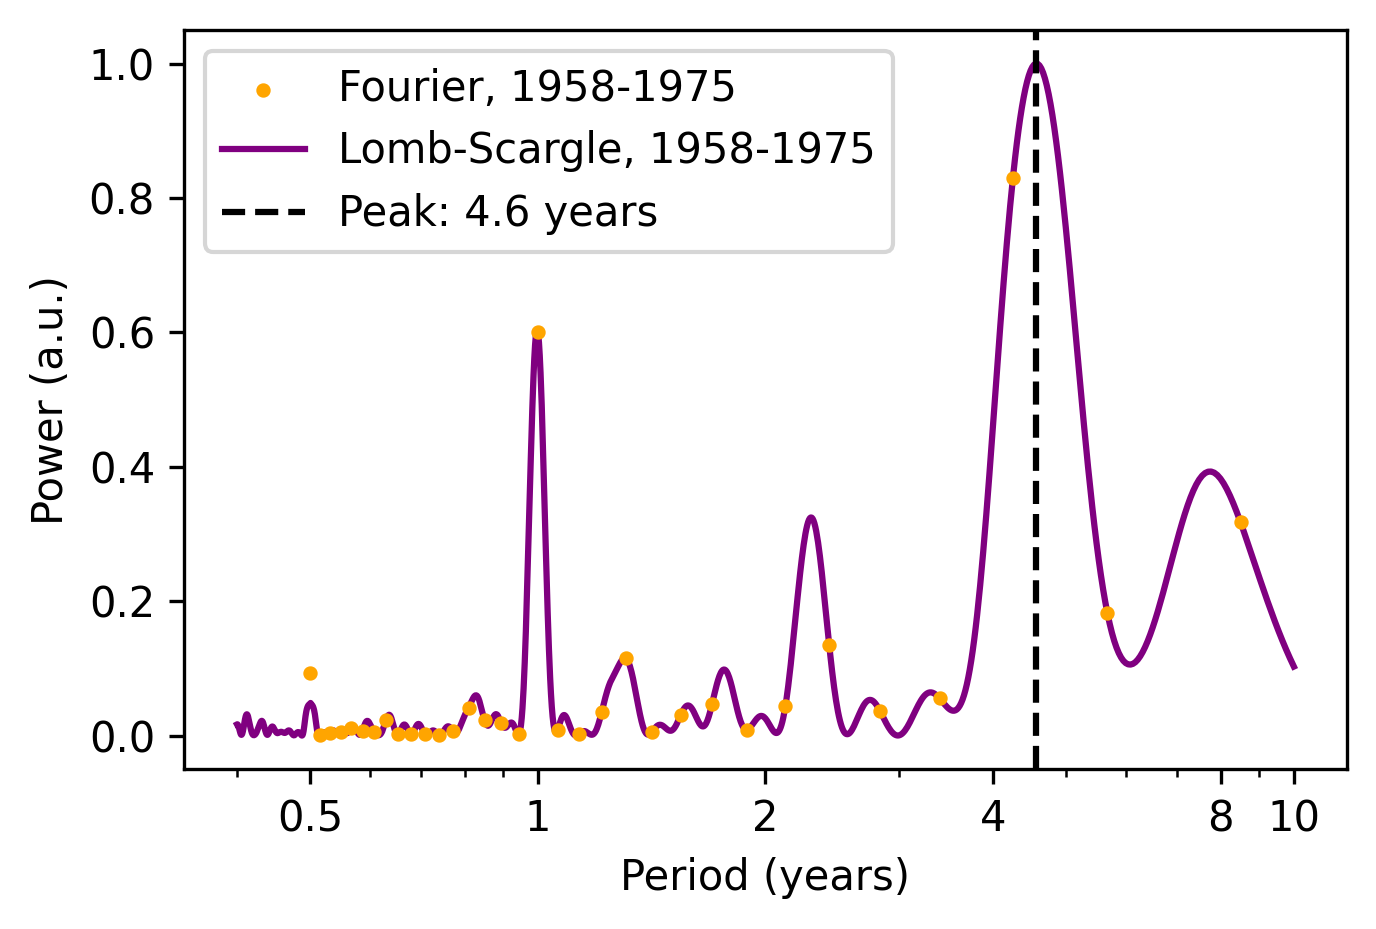

In [6]:
plt.figure(figsize=(5, 3.2), dpi=300)

mintime = 0.0
maxtime = 1975
incdf = data[data['time'] >= mintime]
incdf = incdf[incdf['time'] <= maxtime]
inc_proxy = incdf['PseudoFrac'].fillna(0).values
inc_proxy = np.float64(inc_proxy)

I = inc_proxy

periods, power_nonzero, period_ls, power_ls = get_spectra(I, 4)
periods = periods[::1]
power_nonzero = power_nonzero[::1]

factor = 1/np.max(power_ls[period_ls > 0.5])

power_nonzero *= factor
power_ls *= factor

color1 = "orange"
color2 = "purple"

plt.scatter(periods, power_nonzero, label="Fourier, 1958-1975", s=6, color=color1, zorder=2)
plt.plot(period_ls, power_ls, label="Lomb-Scargle, 1958-1975", color=color2, zorder=1)

plt.xscale('log')
plt.xticks([0.5, 1, 2, 4, 8, 10], labels=[0.5, 1, 2, 4, 8, 10])

# Identify dominant multi-year peak
peak_idx = np.argmax(power_ls[period_ls > 1.5])
dominant_period = period_ls[period_ls > 1.5][peak_idx]
print("early:", dominant_period)
plt.axvline(dominant_period, color='black', linestyle='--', label=f"Peak: {dominant_period:.1f} years", linewidth=1.5)
plt.xlabel("Period (years)")
plt.ylabel("Power (a.u.)")
plt.legend()

peak_idx = np.argmax(power_nonzero[periods > 1.5])
dominant_period = periods[periods > 1.5][peak_idx]
print("Peak Fourier:", dominant_period)

Peak LS: 4.382259767687434
Peak Fourier: 4.2


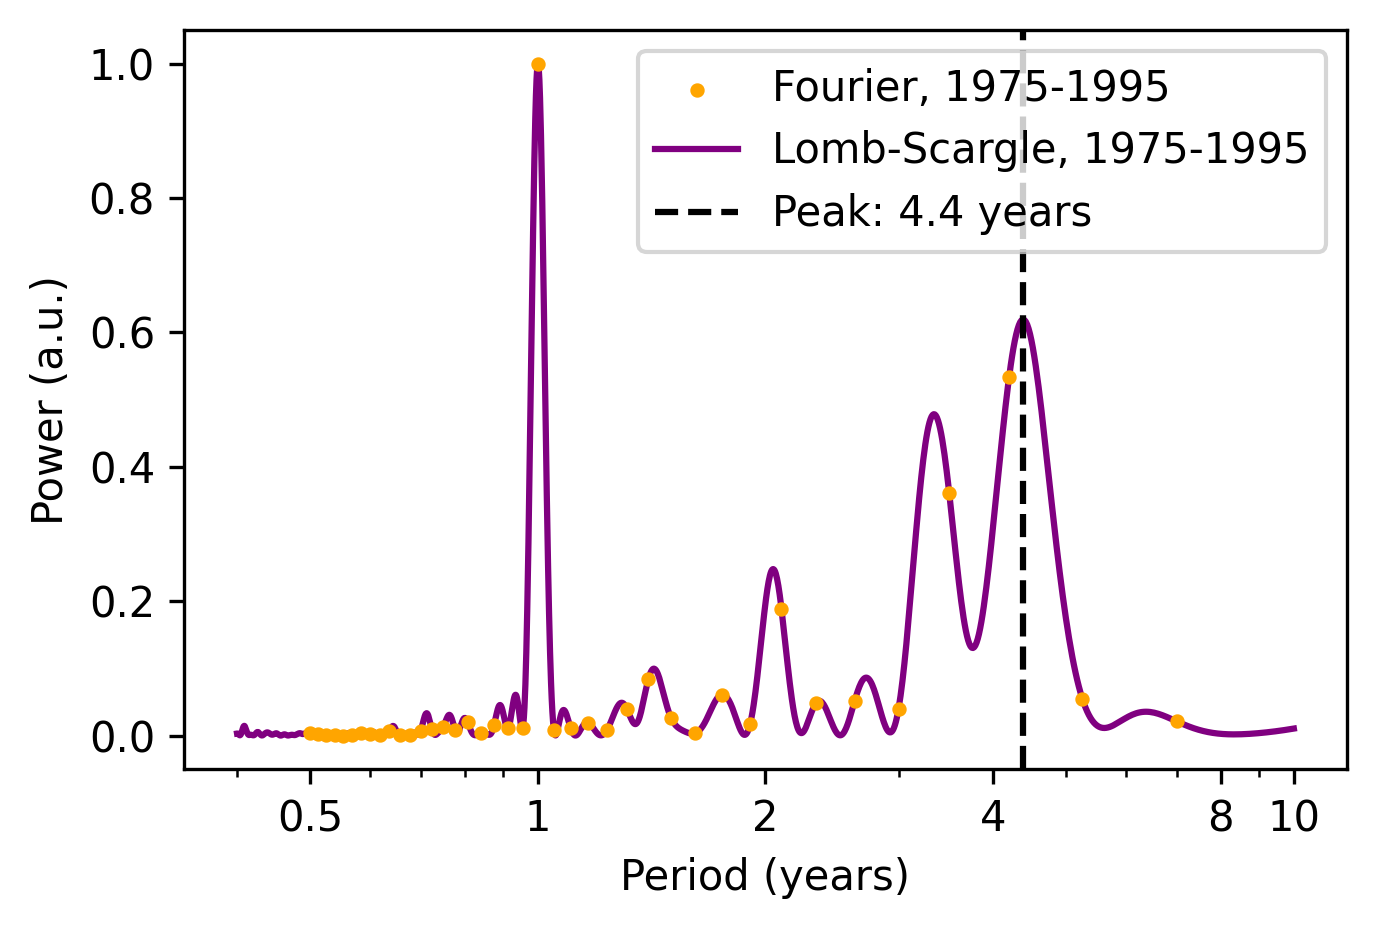

In [7]:
plt.figure(figsize=(5, 3.2), dpi=300)

mintime = 1975.0
maxtime = 2000
incdf = data[data['time'] >= mintime]
incdf = incdf[incdf['time'] <= maxtime]
inc_proxy = incdf['PseudoFrac'].fillna(0).values
inc_proxy = np.float64(inc_proxy)

I = inc_proxy

periods, power_nonzero, period_ls, power_ls = get_spectra(I, 4)
periods = periods[::1]
power_nonzero = power_nonzero[::1]

factor = 1/np.max(power_ls[period_ls > 0.5])

power_nonzero *= factor
power_ls *= factor

color1 = "orange"
color2 = "purple"

plt.scatter(periods, power_nonzero, label="Fourier, 1975-1995", s=6, color=color1, zorder=2)
plt.plot(period_ls, power_ls, label="Lomb-Scargle, 1975-1995", color=color2, zorder=1)

plt.xscale('log')
plt.xticks([0.5, 1, 2, 4, 8, 10], labels=[0.5, 1, 2, 4, 8, 10])

# Identify dominant multi-year peak
peak_idx = np.argmax(power_ls[period_ls > 1.5])
dominant_period = period_ls[period_ls > 1.5][peak_idx]
print("Peak LS:", dominant_period)

plt.axvline(dominant_period, color='black', linestyle='--', label=f"Peak: {dominant_period:.1f} years", linewidth=1.5)
plt.xlabel("Period (years)")
plt.ylabel("Power (a.u.)")
plt.legend()

peak_idx = np.argmax(power_nonzero[periods > 1.5])
dominant_period = periods[periods > 1.5][peak_idx]
print("Peak Fourier:", dominant_period)

Peak LS: 4.087709799675149
Peak Fourier: 4.222222222222222


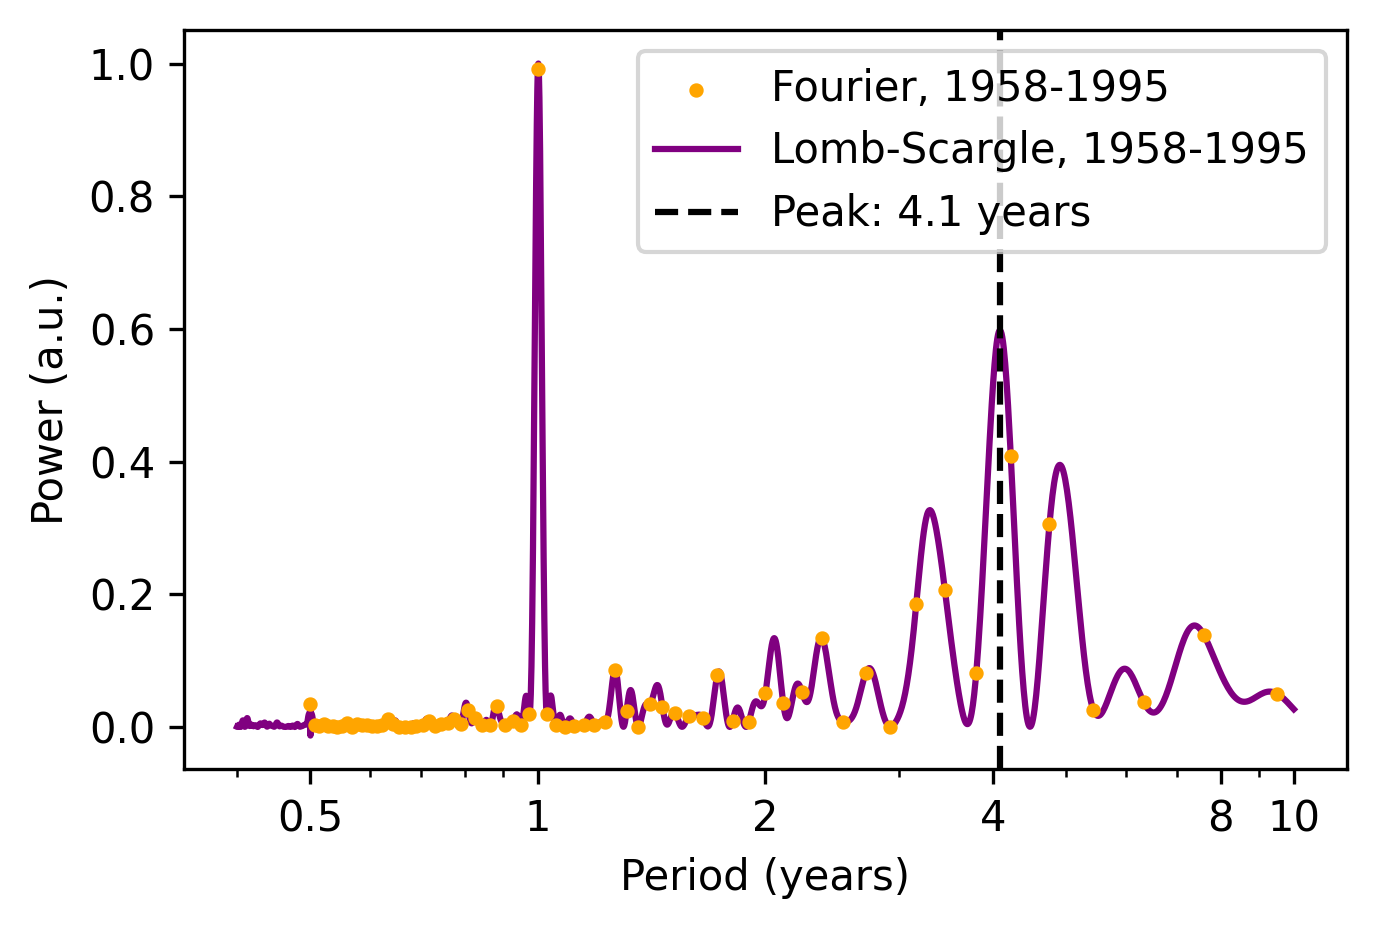

In [8]:
plt.figure(figsize=(5, 3.2), dpi=300)

mintime = 1958.0
maxtime = 2000
incdf = data[data['time'] >= mintime]
incdf = incdf[incdf['time'] <= maxtime]
inc_proxy = incdf['PseudoFrac'].fillna(0).values
inc_proxy = np.float64(inc_proxy)

I = inc_proxy

periods, power_nonzero, period_ls, power_ls = get_spectra(I, 4)
periods = periods[::1]
power_nonzero = power_nonzero[::1]

factor = 1/np.max(power_ls[period_ls > 0.5])

power_nonzero *= factor
power_ls *= factor

color1 = "orange"
color2 = "purple"

plt.scatter(periods, power_nonzero, label="Fourier, 1958-1995", s=6, color=color1, zorder=2)
plt.plot(period_ls, power_ls, label="Lomb-Scargle, 1958-1995", color=color2, zorder=1)

plt.xscale('log')
plt.xticks([0.5, 1, 2, 4, 8, 10], labels=[0.5, 1, 2, 4, 8, 10])

# Identify dominant multi-year peak
peak_idx = np.argmax(power_ls[period_ls > 1.5])
dominant_period = period_ls[period_ls > 1.5][peak_idx]
print("Peak LS:", dominant_period)

plt.axvline(dominant_period, color='black', linestyle='--', label=f"Peak: {dominant_period:.1f} years", linewidth=1.5)
plt.xlabel("Period (years)")
plt.ylabel("Power (a.u.)")
plt.legend()

peak_idx = np.argmax(power_nonzero[periods > 1.5])
dominant_period = periods[periods > 1.5][peak_idx]
print("Peak Fourier:", dominant_period)